In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [5]:
forecasting_horizon = 12

nb_windows = 12
step_size = 1

lags = [2, 5, 6, 11, 12]
date_features = ["month", "year"]

regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED, n_jobs=-1),
                      GradientBoostingRegressor(random_state=SEED)]
regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor"]
save_path="lab/models_skforecast/monthly/"

In [6]:
def load_and_preprocess_daily_data(start_index, end_index, date_features):
    index_type = "DatetimeIndex"
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", index_type=index_type, freq="H", start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="M", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[1], freq="M", index_type=index_type, start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")
    co2_df = icap_provider.get_series(icap_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
    lags = []

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)

    data_train = df_date_features.iloc[:-forecasting_horizon, :].copy()
    data_test = df_date_features.iloc[-forecasting_horizon:, :].copy()

    initial_window_length = len(data_train) - step_size*(nb_windows-1)

    return data_train, data_test, initial_window_length

In [7]:
index_type = "DatetimeIndex"
start_index="2014-01-01"
end_index="2023-03-31"
co2_df = icap_provider.get_series(icap_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")

In [8]:
len(co2_df)

111

In [9]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2014-01-01", end_index="2023-03-31", date_features=date_features)
print(initial_window_length)

88


Model: KNeighborsRegressor
MASEs: [2.239628467684869, 2.4494252076690737, 2.990995617491434, 2.944380916629762, 3.2423436279993876, 3.5698173253206313, 3.819068254313703, 4.111295358870556]
MAEs: [11.263375474274033, 12.276428124080402, 15.157262261032983, 14.773417574807548, 16.127715451306127, 17.790514262227727, 19.052270995017242, 20.531598125985813]
Fit time: 0.1876375675201416

Model: RandomForestRegressor
MASEs: [1.4219607314447, 1.4869136376175334, 1.7825684287338268, 1.631800509900668, 1.7340177698086565, 1.8431857135969312, 1.963160795522682, 2.129695447524748]
MAEs: [7.151220775690092, 7.452355900385901, 9.03339911785527, 8.187551479969665, 8.6251638899354, 9.185686195507323, 9.793664054274183, 10.635589818419646]
Fit time: 2.031829595565796

Model: GradientBoostingRegressor
MASEs: [0.9483708253453624, 1.0392282827628998, 1.3493788151016448, 1.7793607275925047, 1.9326440055322167, 1.9922188929652067, 2.1150302627825863, 2.363631615560138]
MAEs: [4.76947710249189, 5.208573537

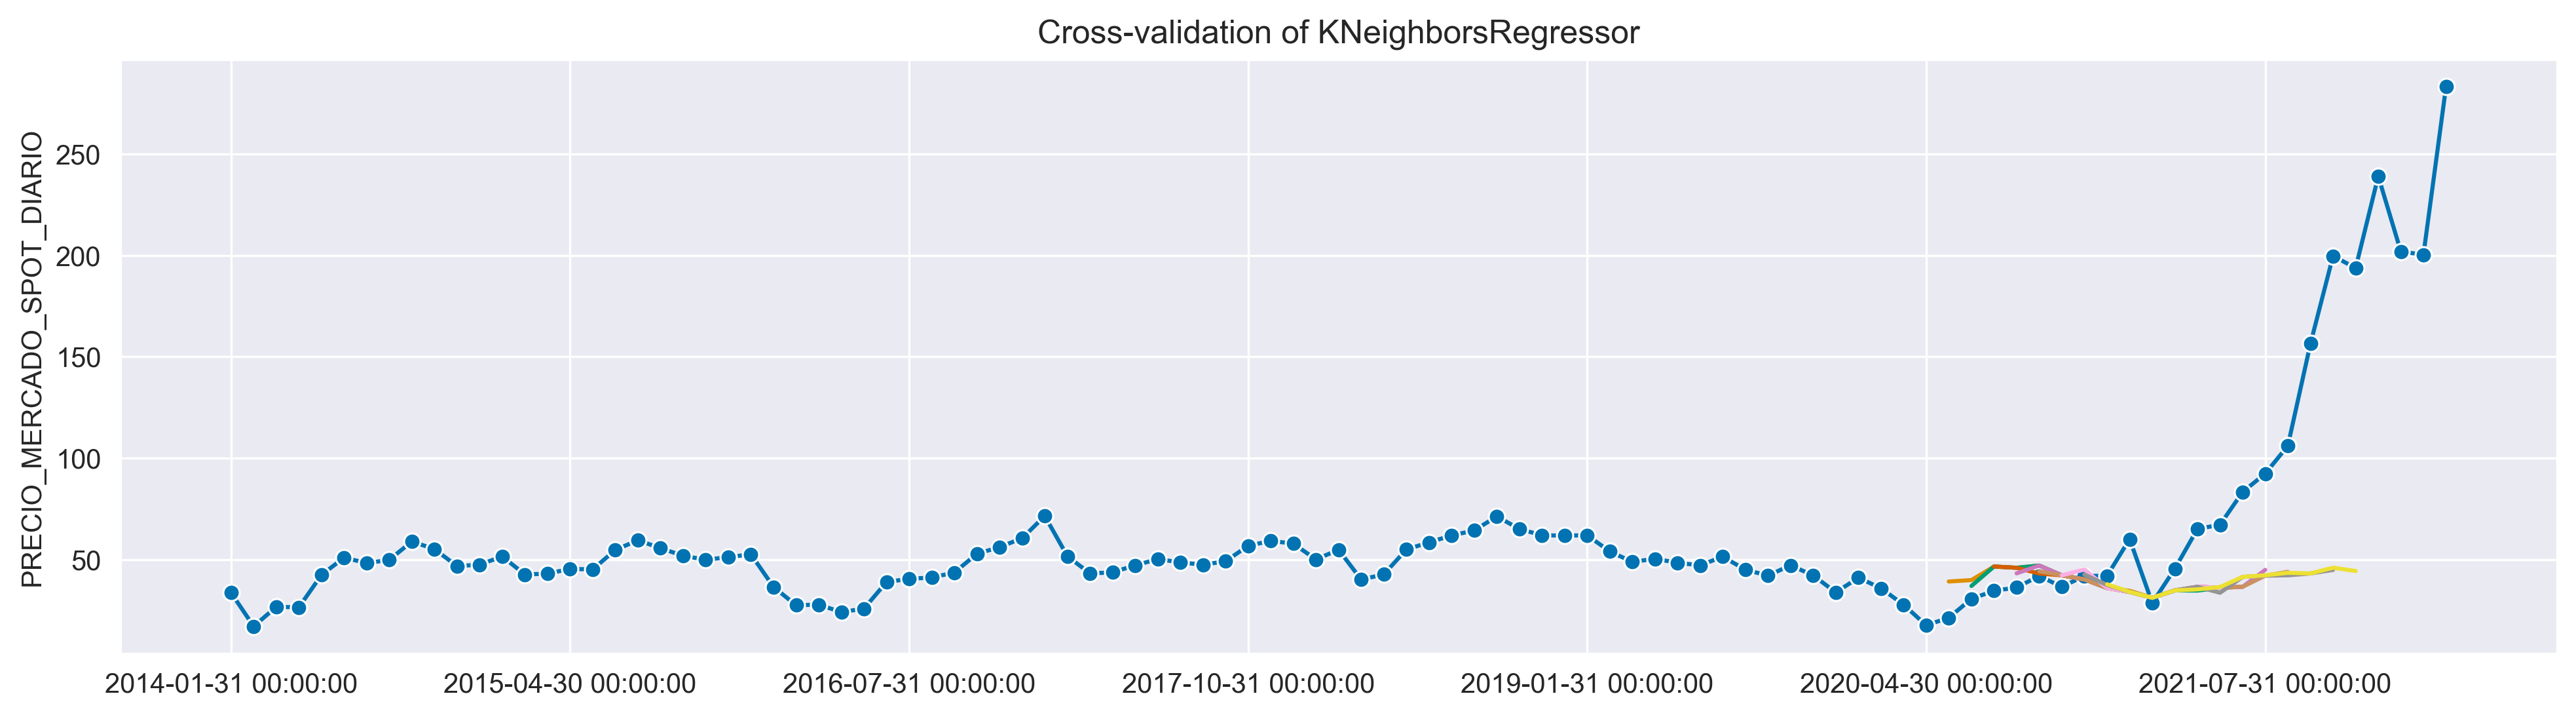

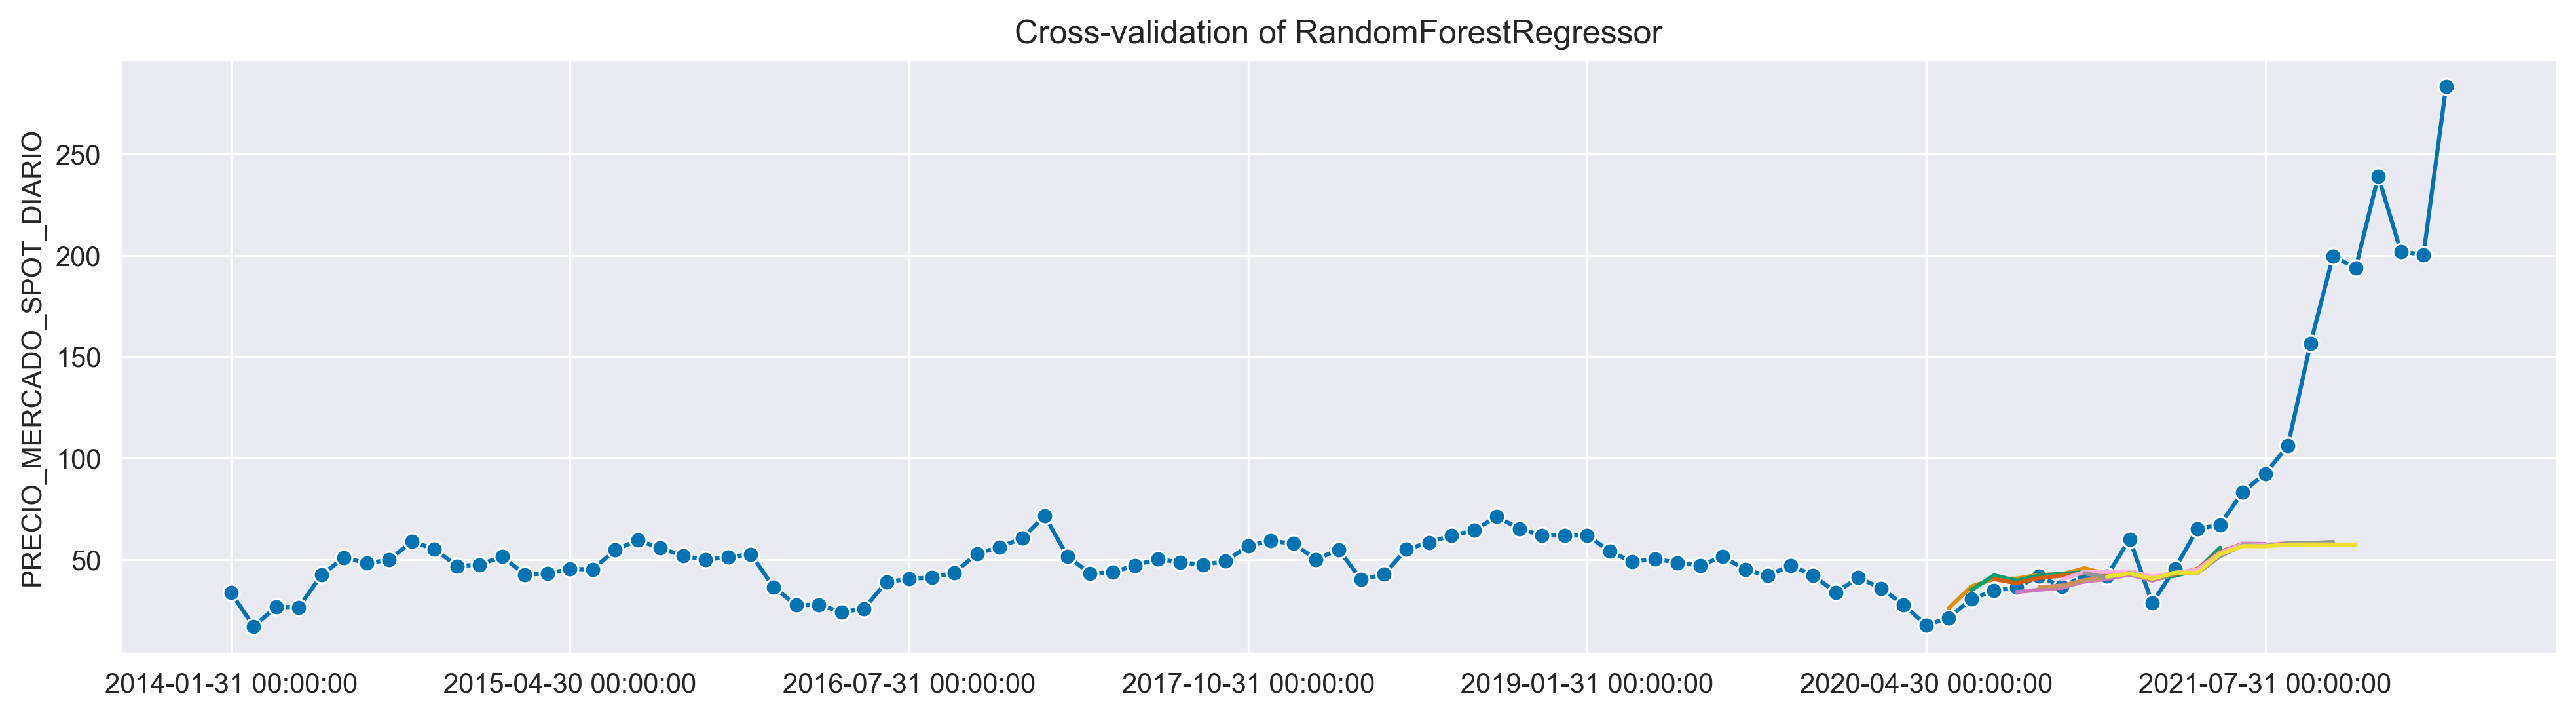

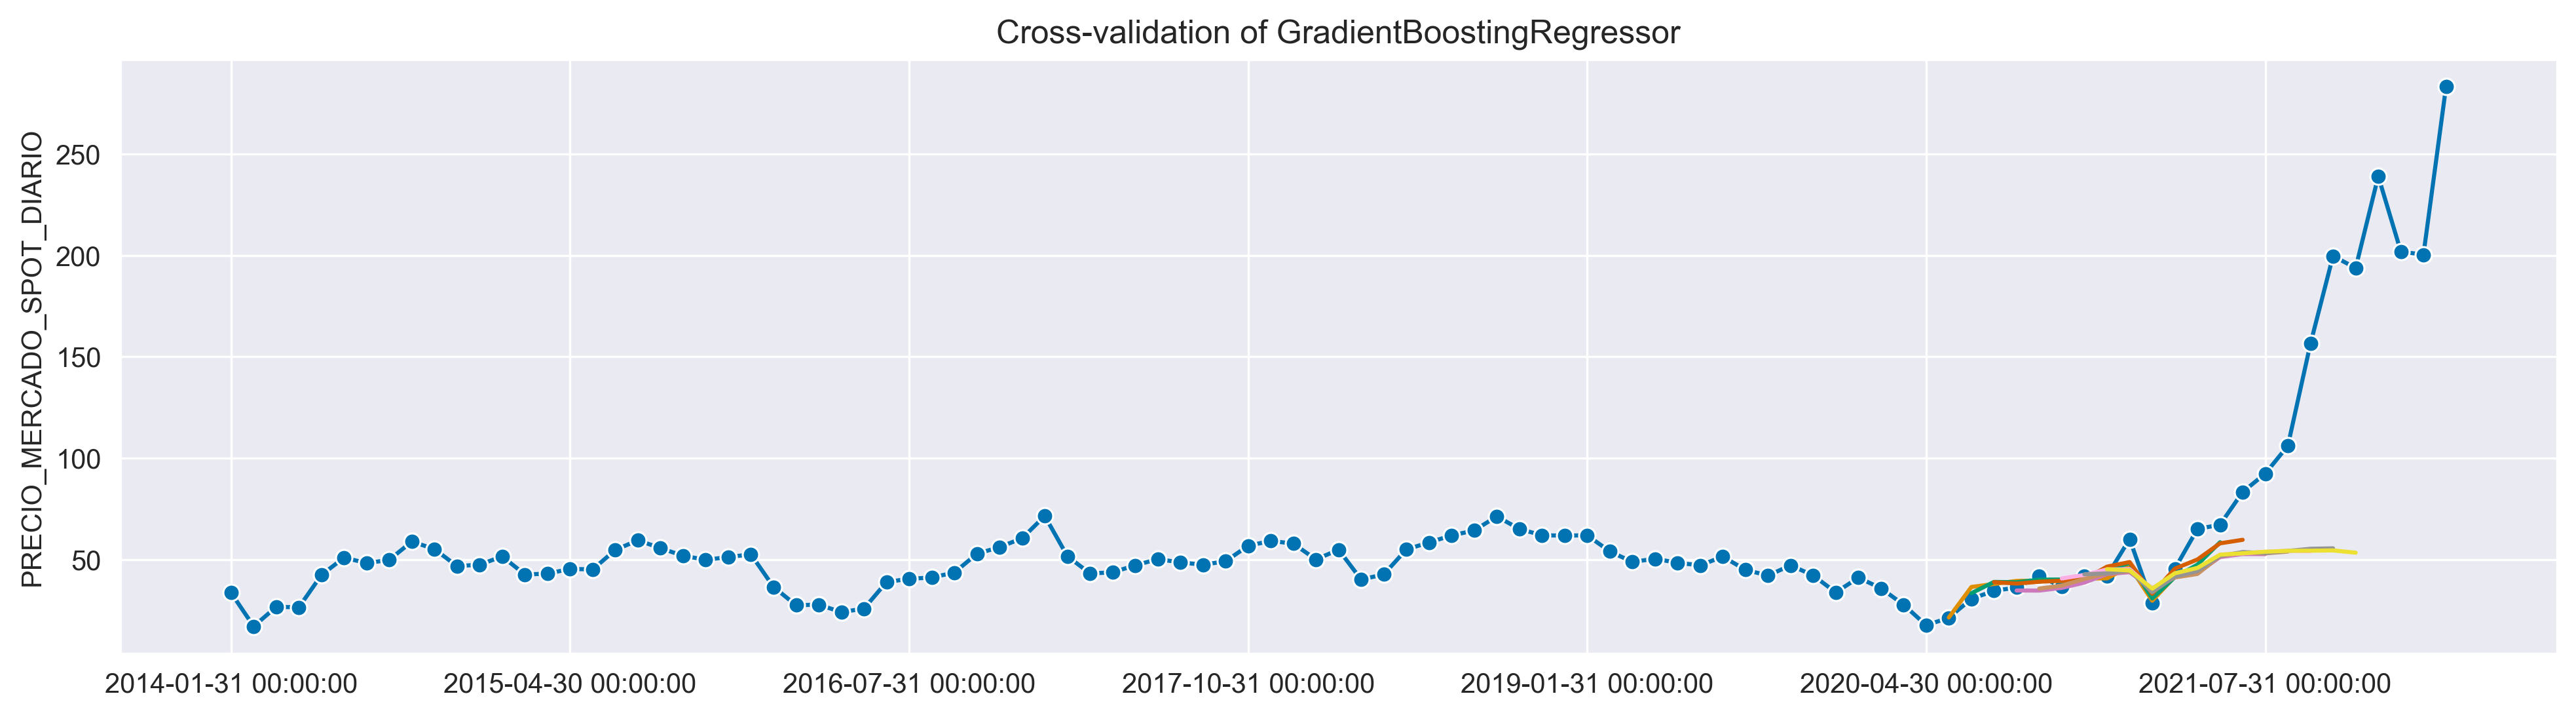

In [10]:
cv_results_df_summary = func.crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

In [12]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

,model,mean_mase,mean_mae,fit_time
2,GradientBoostingRegressor,1.689983,8.455106,0.809040
1,RandomForestRegressor,1.749163,8.758079,2.031830
0,KNeighborsRegressor,3.170869,15.871573,0.187638


In [13]:
save_name="monthly.pkl"
os.makedirs(save_path, exist_ok=True)
cv_results_df_summary.to_pickle(save_path + save_name)

In [14]:
cv_results_df = pd.read_pickle(save_path+save_name)

### Final model

In [15]:
data_train_iso, data_test_iso = func.remove_outliers_isolation_forests_train_test(data_train, data_test, columns=[column for column in data_train.columns if column not in date_features])

In [16]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]

forecaster = ForecasterAutoreg(
                 regressor     = best_model,
                 lags          = lags
             )

forecaster.fit(
    y       = data_train_iso.iloc[:, 0],
    exog    = data_train_iso.iloc[:, 1:],
)

In [17]:
y_pred = forecaster.predict(
    steps   = forecasting_horizon,
    exog    = data_test_iso.iloc[:, 1:]
)

y_pred = pd.Series(data=y_pred, index=data_test_iso.iloc[:, 0].index)

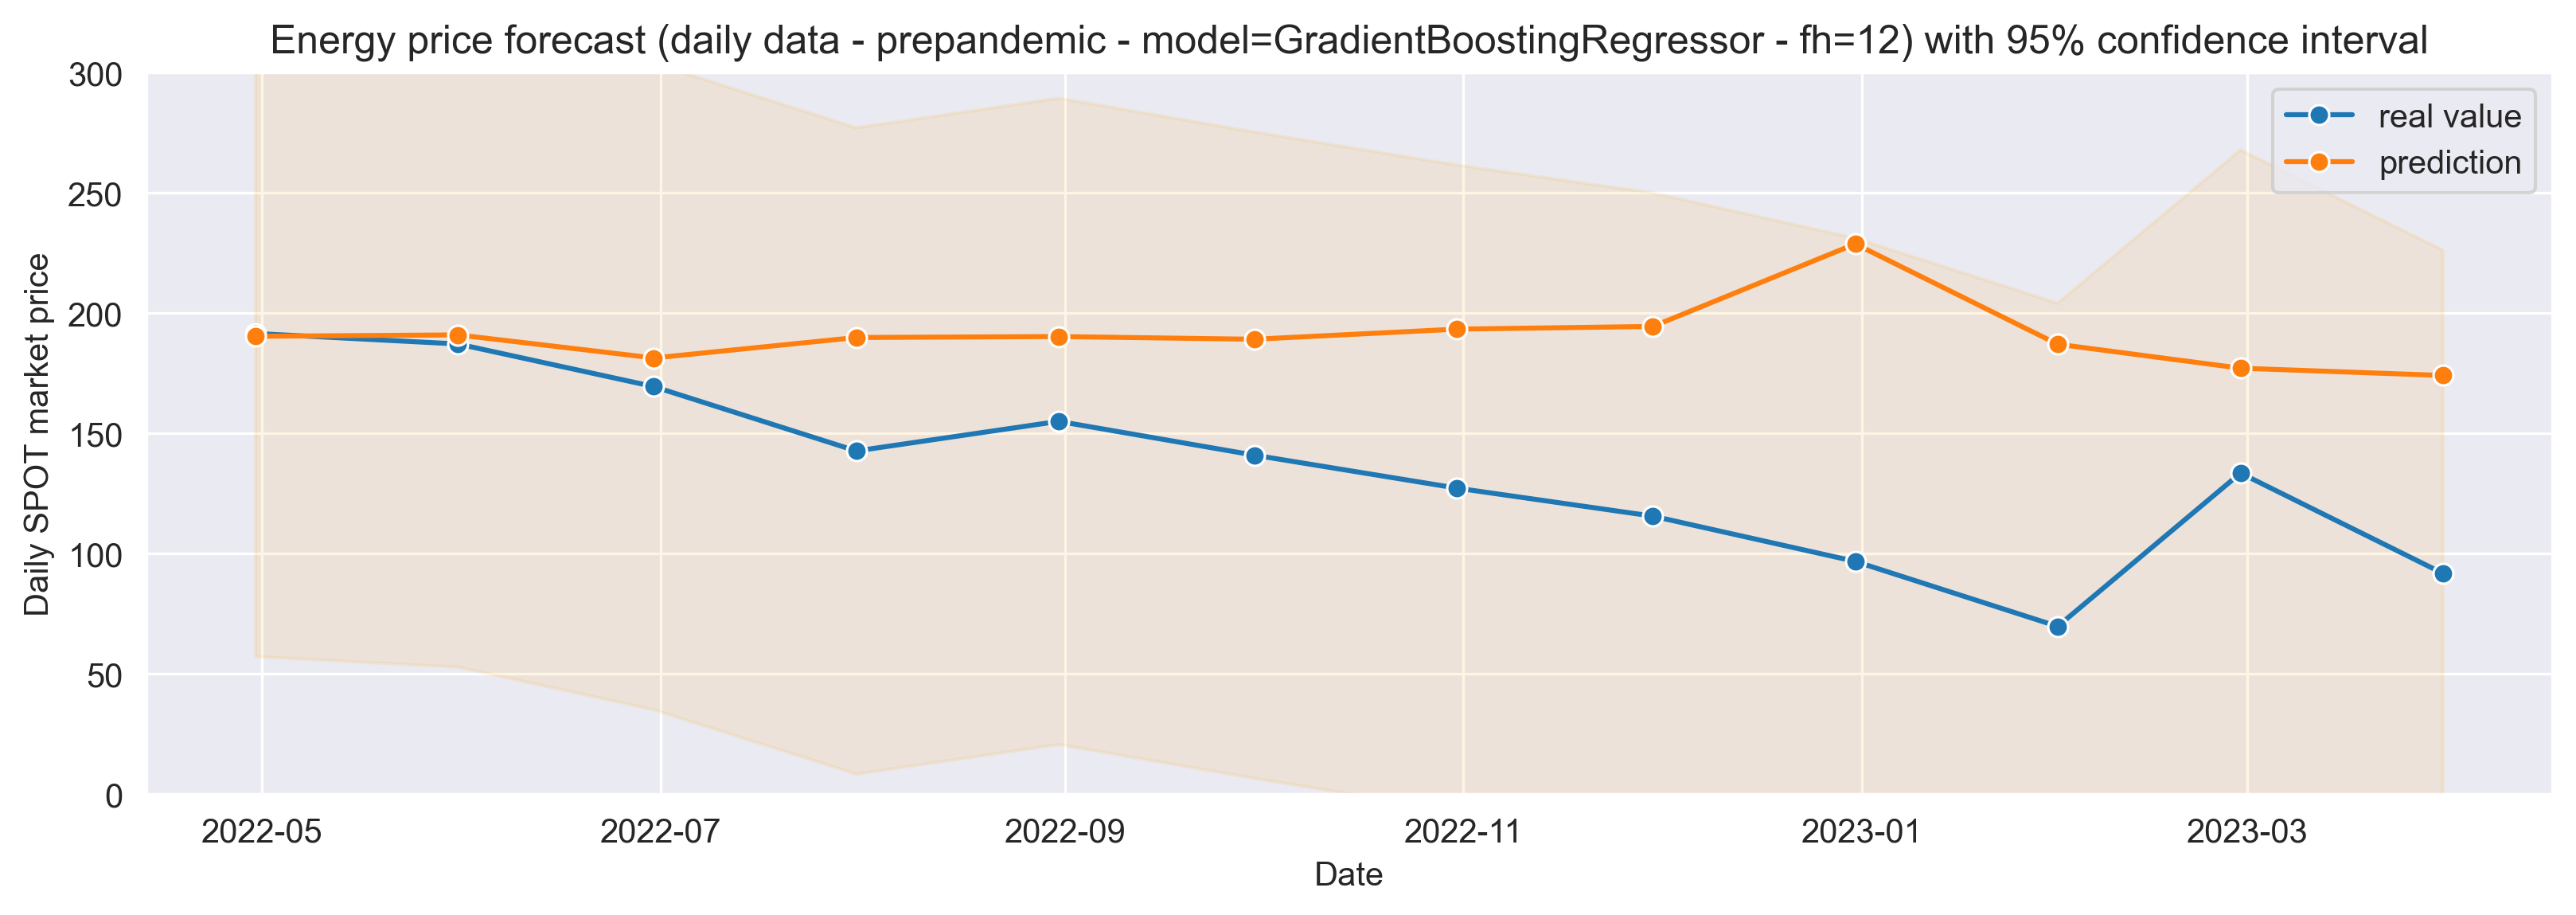

In [20]:
residuals = abs(y_pred-data_test_iso.iloc[:, 0])
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(data_test_iso.iloc[:, 0].index) is pd.core.indexes.period.PeriodIndex:
    data_test_iso.iloc[:, 0].index = data_test_iso.iloc[:, 0].index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(13,4))
sns.lineplot(data=data_test_iso.iloc[:, 0], palette="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, palette="orange", marker="o", ax=ax)
ax.fill_between(data_test_iso.iloc[:, 0].index, (data_test_iso.iloc[:, 0]-band_size), (data_test_iso.iloc[:, 0]+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - prepandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
ax.set_ylim([0,300])
ax.legend(loc="upper right", labels=["real value", "prediction"])
plt.show()